In [1]:
from fastai.collab import *
from fastai.tabular import *
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

In [2]:
def get_data(path, standard_type = 'KD', standard_unit='NM', transformation = None):
    df_all = pd.read_csv(path, usecols=['compound_id', 'target_id',
                                        'standard_type', 'standard_relation', 'standard_value', 'standard_units'])
    df_filtered = df_all[df_all.standard_value!=0].copy()
    df_filtered = df_filtered[(df_all.standard_type==standard_type) & 
                              (df_all.standard_relation=='=') &
                              (df_all.standard_units==standard_unit)].dropna().copy()
    df_filtered = df_filtered[~df_filtered.target_id.str.contains(',')]
    if transformation == None:
        target_name = standard_type
        df_filtered[target_nanme] = df_filtered['standard_value']
    else:
        target_name = standard_type + transformation.__name__
        df_filtered[target_name] = transformation(df_filtered['standard_value'])
    
    return df_filtered, target_name

In [3]:
def plot_preds(pred, target, target_name='target'):
    # plot a comparison between prediction and actual result
    fig, ax = plt.subplots(1, 2)
    axis_min = np.min([np.array(pred).flatten().min(), np.array(target).flatten().min()])
    axis_max = np.max([np.array(pred).flatten().max(), np.array(target).flatten().max()])
    ax[0].scatter(pred, target, alpha=0.02)
    ax[0].set_xlim([axis_min, axis_max])
    ax[0].set_xlabel(target_name + ' prediction')
    ax[0].set_ylim([axis_min, axis_max])
    ax[0].set_ylabel(target_name + ' actual')
    ax[0].set_aspect('equal')
    slope, intercept, r_value, p_value, std_err = stats.linregress(pred, target.flatten())
    ax[0].set_title("r_squared: {}".format(r_value**2) + "slope: {}".format(slope))
    ax[1].hist(np.array(pred).flatten()-np.array(target).flatten(), np.linspace(-10, 10, 100))
    ax[1].set_title('Histogram of prediction-target')

In [4]:
path = Path('/home/jupyter/.fastai/data/kinase/DTC_data.csv')

In [32]:
columns = df_DTC.columns; columns

Index(['compound_id', 'standard_inchi_key', 'compound_name', 'synonym',
       'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant',
       'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'activity_comment',
       'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype',
       'inhibitor_type', 'detection_tech', 'assay_cell_line',
       'compound_concentration_value', 'compound_concentration_value_unit',
       'substrate_type', 'substrate_relation', 'substrate_value',
       'substrate_units', 'assay_description', 'title', 'journal', 'doc_type',
       'annotation_comments'],
      dtype='object')

In [5]:
df_Kd, target_name = get_data(path, standard_type='KD', standard_unit='NM', transformation=np.log)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [6]:
df_Kd.tail()

,compound_id,target_id,standard_type,standard_relation,standard_value,standard_units,KDlog
5932528,CHEMBL3545051,P36888,KD,=,74.0,NM,4.304065
5959350,CHEMBL3545051,P10721,KD,=,280.0,NM,5.634790
5971861,CHEMBL3545051,P00533,KD,=,140.0,NM,4.941642
5971862,CHEMBL3545051,P00533,KD,=,25.0,NM,3.218876
5977267,CHEMBL3545267,O35904,KD,=,6.2,NM,1.824549


In [7]:
df_Kd.shape

(32536, 7)

In [130]:
df_Kd_train = df_Kd.iloc[:26000, :].copy()
df_Kd_test = df_Kd.iloc[26001:, :].copy()

In [9]:
df_Kd[target_name].describe()

count    32536.000000
mean         5.383024
std          3.440766
min        -18.420681
25%          2.995732
50%          5.703782
75%          7.649693
max         25.328436
Name: KDlog, dtype: float64

In [10]:
df_Kd.standard_units.unique()

array(['NM'], dtype=object)

# Generate data

In [11]:
Kd_data = CollabDataBunch.from_df(df_Kd, user_name='compound_id',
                                         item_name='target_id',
                                         rating_name=target_name, 
                                         pct_val=0.1,
                                         seed=40)

In [12]:
Kd_data.show_batch()

compound_id,target_id,target
CHEMBL327351,O02824,2.532902956008911
CHEMBL574738,Q8TDR2,2.7725887298583984
CHEMBL607707,P08581,8.732304573059082
CHEMBL603469,P17612,5.393627643585205
CHEMBL464552,Q9Y463,6.877295970916748


# Model using embedding

In [18]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[-15, 25])

In [19]:
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


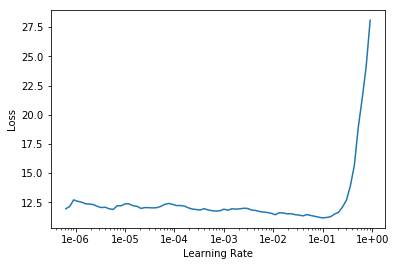

In [20]:
Kd_learn.recorder.plot()

In [21]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,8.184510,7.650611
2,4.755052,5.509583
3,2.739308,5.085732
4,1.471089,5.001460
5,1.110643,4.962924


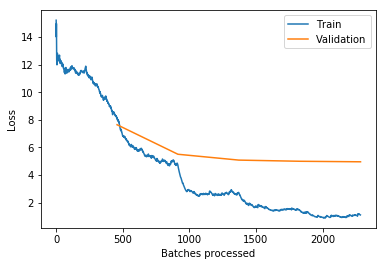

In [22]:
Kd_learn.recorder.plot_losses()

In [23]:
Kd_learn.show_results(rows=10)

compound_id,target_id,target,prediction
CHEMBL428690,Q15303,8.517192840576172,7.909543991088867
#na#,Q63844,-1.272965669631958,1.2068328857421875
#na#,P31389,1.381281852722168,5.549800872802734
CHEMBL535,Q96SB4,5.521461009979248,6.474079132080078
CHEMBL464552,P49760,2.7725887298583984,6.30537223815918
#na#,Q99816,10.878046989440918,9.558086395263672
CHEMBL601719,O43318,7.495542049407959,6.773155212402344
CHEMBL1233735,Q8N1Q1,3.332204580307007,4.62750244140625
#na#,P9WNS1,4.499809741973877,4.701881408691406
#na#,A1XG20,5.438079357147217,5.255607604980469


In [24]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)

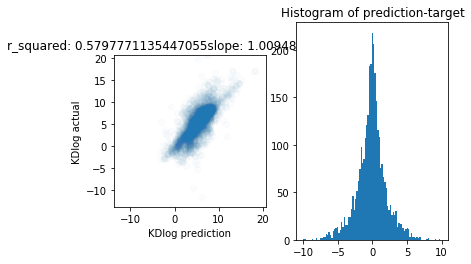

In [90]:
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

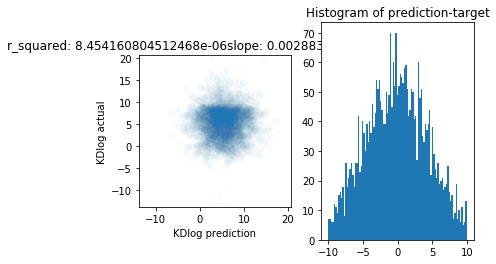

In [91]:
# bench mark: no prediction at all
random_preds = (np.random.randn(len(Kd_preds[1]))*df_Kd[target_name].describe()['std']+
                df_Kd[target_name].describe()['mean'])
plot_preds(random_preds, Kd_preds[1], target_name)

### There are a bunch of #na# in validation set for compound id. This is because these compounds were not found in the training dataset. For simplicity, let's ignore them for now. The result (r2) improves as expected.

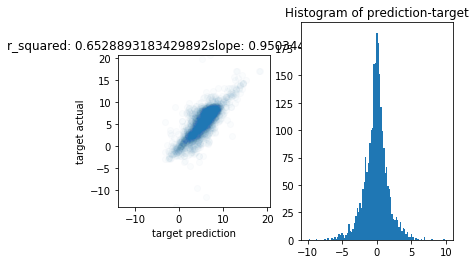

In [119]:
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))

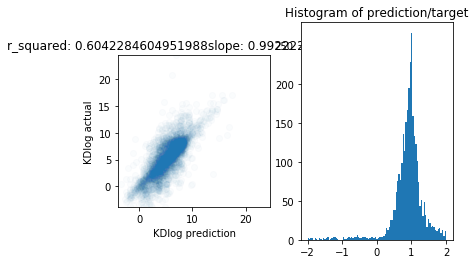

In [85]:
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

In [86]:
Kd_learn.save('Kd_embedding_r2_0.6')

# Try weight decay (regularization). Default is 1e-2 as used above. There is little difference between 1e-1 and 1e-2

In [13]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[-15, 25], wd=1e-1)

In [14]:
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


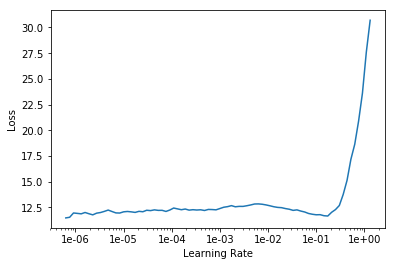

In [15]:
Kd_learn.recorder.plot()

In [16]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,8.120308,7.666423
2,4.853170,5.523676
3,2.751787,5.155199
4,1.735300,4.999946
5,1.176487,4.990834


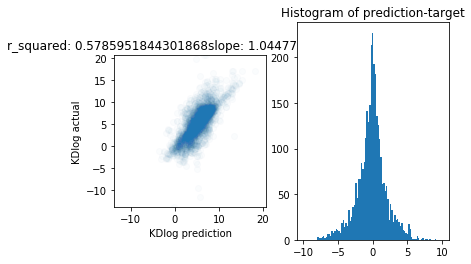

In [17]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

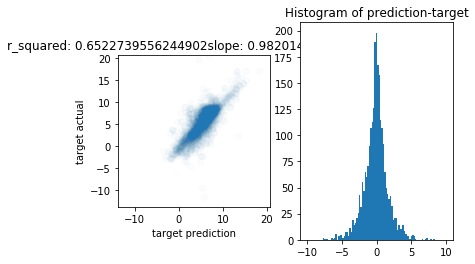

In [18]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))

# Try 10X faster and 10X lower learning rate. It's interesting that 5e-3 is the best. Similar to what Jeremy found for MovieLens data.

### lr = 5e-2

In [21]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[-15, 25])
Kd_learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss
1,6.417176,6.560821
2,15.631054,18.196354
3,37.586300,34.687431
4,43.851486,36.916115
5,40.031815,27.955383
6,28.722246,19.873878
7,17.183010,12.312285
8,9.305803,8.077348
9,4.113434,6.622826
10,1.799497,6.525928


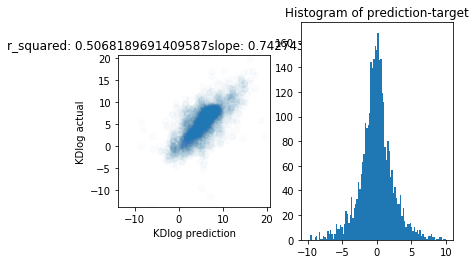

In [22]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

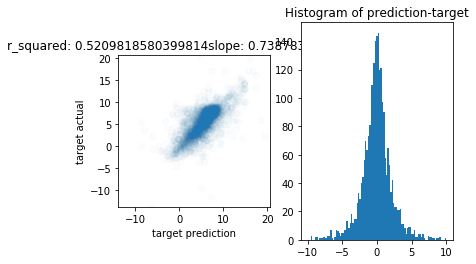

In [23]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))

### lr = 5e-4

In [24]:
Kd_learn = collab_learner(Kd_data, n_factors=20, y_range=[-15, 25])
Kd_learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss
1,11.910674,11.683726
2,10.521902,10.659747
3,9.360650,9.085281
4,7.221163,7.903999
5,6.045321,7.173052
6,5.252468,6.734390
7,4.527296,6.491581
8,4.055036,6.373045
9,3.810684,6.328660
10,4.172243,6.322311


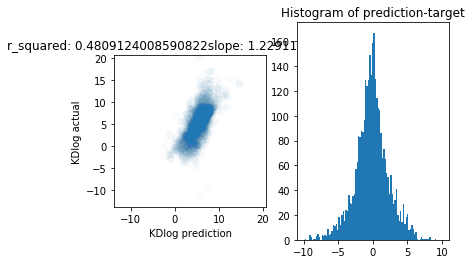

In [25]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

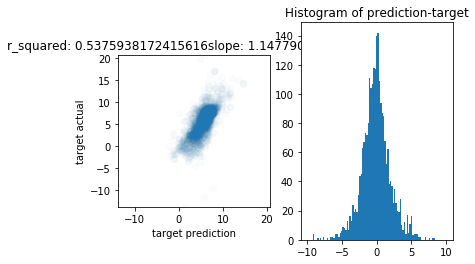

In [26]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))

# Try n_factor = 10, 40, 80. n_factor = 40 is better among the three. Similar to n_factor = 20.

### n_factor = 10

In [32]:
Kd_learn = collab_learner(Kd_data, n_factors=10, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


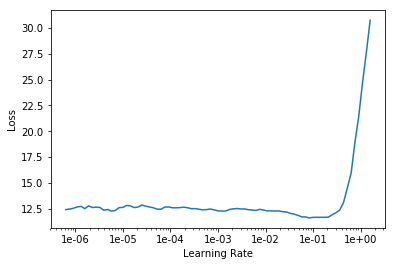

In [33]:
Kd_learn.recorder.plot()

In [34]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,8.454808,7.874775
2,5.140191,5.658759
3,3.240876,5.223125
4,2.149196,5.093817
5,1.663888,5.086522


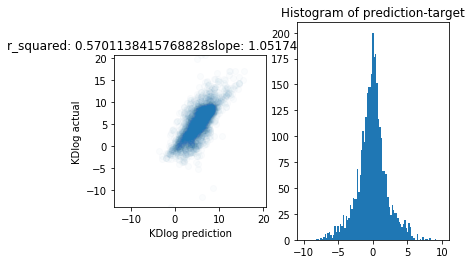

In [35]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

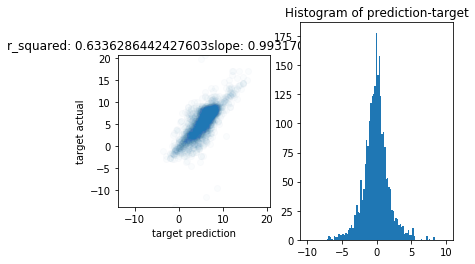

In [36]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))

### n_factor = 40

In [37]:
Kd_learn = collab_learner(Kd_data, n_factors=40, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


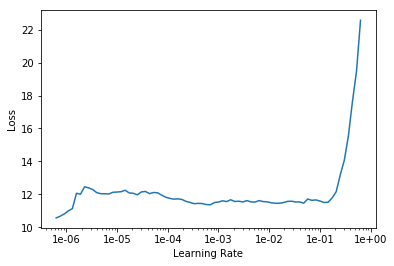

In [38]:
Kd_learn.recorder.plot()

In [39]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,8.194882,7.510364
2,4.669420,5.595807
3,2.537656,5.249796
4,1.466760,5.057349
5,1.140410,5.035991


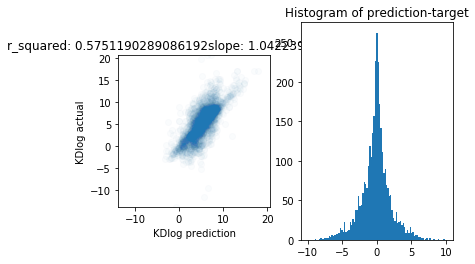

In [40]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

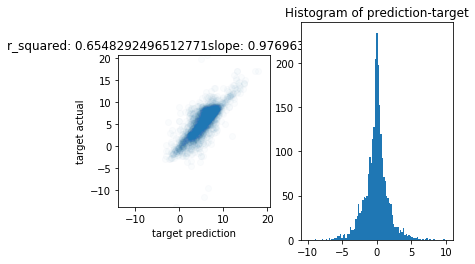

In [41]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))

### n_factor = 80

In [42]:
Kd_learn = collab_learner(Kd_data, n_factors=80, y_range=[-15, 25], wd=1e-1)
Kd_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


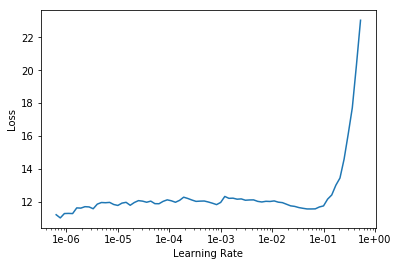

In [43]:
Kd_learn.recorder.plot()

In [44]:
Kd_learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss
1,7.636324,7.266421
2,4.675344,5.664279
3,2.760693,5.392367
4,1.734282,5.165274
5,0.911765,5.148204


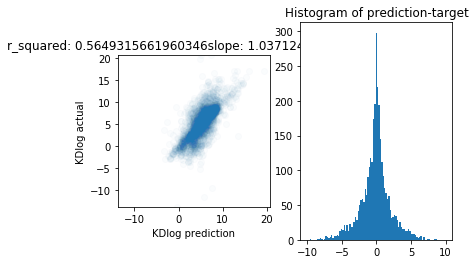

In [45]:
Kd_preds = Kd_learn.get_preds(ds_type=DatasetType.Valid)
plot_preds(Kd_preds[0], Kd_preds[1], target_name)

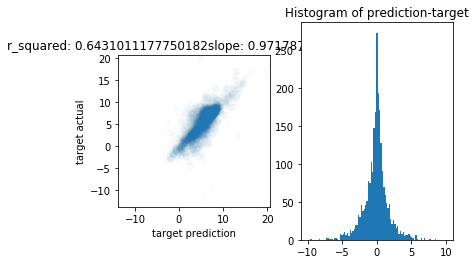

In [46]:
# get rid of those cold starts
Kd_learn_valid_df = pd.DataFrame(data=[str(i).split(';')[0] for i in list(Kd_learn.data.valid_ds.x)],
                                 columns=['compound_id'])
Kd_learn_valid_df['target_id'] = [str(i).split(';')[1] for i in list(Kd_learn.data.valid_ds.x)]
Kd_learn_valid_df['prediction'] = Kd_preds[0]
Kd_learn_valid_df['target'] = Kd_preds[1]
plot_preds(np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['prediction']),
           np.array(Kd_learn_valid_df[~Kd_learn_valid_df.compound_id.str.contains('#na#')]['target']))

# embedding NN (https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00)

In [269]:
Kd_NN = collab_learner(Kd_data, use_nn=True, 
                       emb_szs={'compound_id': 40, 'target_id':40}, layers=[256, 128], y_range=(-20, 30))

In [270]:
Kd_NN.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


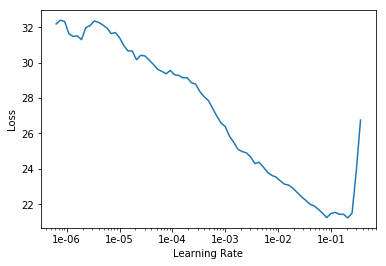

In [271]:
Kd_NN.recorder.plot()

In [272]:
Kd_NN.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss
1,8.092835,7.002777
2,7.083485,6.826031
3,5.260640,6.407361
4,4.042236,5.750410
5,3.379128,5.433368
6,2.762931,5.120790
7,2.096077,5.052482
8,1.783967,4.964086
9,1.583162,5.192410
10,1.353708,5.019313


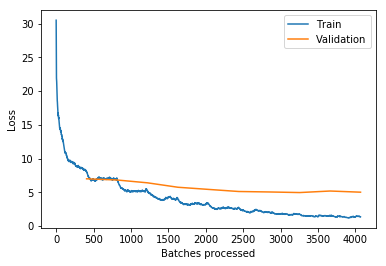

In [273]:
Kd_NN.recorder.plot_losses()

In [274]:
Kd_NN.show_results()

compound_id,target_id,target,prediction
CHEMBL2024149,P0DMS8,-0.8278220891952515,3.687488555908203
CHEMBL1544,P10827,-2.8473122119903564,-2.4090042114257812
CHEMBL265556,P30968,0.0,0.11651229858398438
CHEMBL1721885,Q9Y4K4,5.703782558441162,5.274375915527344
CHEMBL522892,Q16513,9.200289726257324,8.28076171875


In [275]:
Kd_NN_preds = Kd_NN.get_preds()

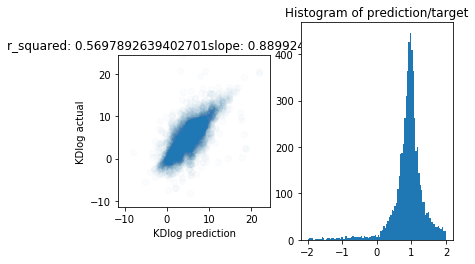

In [276]:
plot_preds(Kd_NN_preds[0].flatten(), Kd_NN_preds[1], target_name)

## TODO
1. #na# issue. see this https://forums.fast.ai/t/tabular-issue-spliting-to-validation-results-in-random-na-in-data/37268 (done)
1. explore the effect of embedding